## Задание 1. Написать теггер на данных с русским языком

In [1]:
!pip install pyconll
!mkdir datasets
!wget -O ./datasets/ru_syntagrus-ud-train.conllu https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-train.conllu
!wget -O ./datasets/ru_syntagrus-ud-dev.conllu https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-dev.conllu

--2021-07-23 05:41:35--  https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-train.conllu
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81039282 (77M) [text/plain]
Saving to: ‘./datasets/ru_syntagrus-ud-train.conllu’

./datasets/ru_synta 100%[===================>]  77.28M   199MB/s    in 0.4s    

2021-07-23 05:41:35 (199 MB/s) - ‘./datasets/ru_syntagrus-ud-train.conllu’ saved [81039282/81039282]

--2021-07-23 05:41:35--  https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-dev.conllu
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercont

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import pyconll

from gensim.models import Word2Vec, FastText

from nltk.tag import UnigramTagger, BigramTagger, TrigramTagger, SequentialBackoffTagger
from nltk.corpus import names
import nltk
nltk.download('names')

[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.


True

### Loading dta

In [3]:
full_train = pyconll.load_from_file('datasets/ru_syntagrus-ud-train.conllu')
full_test = pyconll.load_from_file('datasets/ru_syntagrus-ud-dev.conllu')

In [4]:
def convert_data(dataset):
    result = []

    for sent in dataset:
        for token in sent:
            result.append((token.form.lower(), token.upos))
            
    return result

In [5]:
train_data = convert_data(full_train) 
train_data[:10]

[('анкета', 'NOUN'),
 ('.', 'PUNCT'),
 ('начальник', 'NOUN'),
 ('областного', 'ADJ'),
 ('управления', 'NOUN'),
 ('связи', 'NOUN'),
 ('семен', 'PROPN'),
 ('еремеевич', 'PROPN'),
 ('был', 'AUX'),
 ('человек', 'NOUN')]

In [6]:
test_data = convert_data(full_test) 
test_data[:10]

[('алгоритм', 'NOUN'),
 (',', 'PUNCT'),
 ('от', 'ADP'),
 ('имени', 'NOUN'),
 ('учёного', 'NOUN'),
 ('аль', 'PART'),
 ('-', 'PUNCT'),
 ('хорезми', 'PROPN'),
 (',', 'PUNCT'),
 ('-', 'PUNCT')]

### 1. проверить UnigramTagger, BigramTagger, TrigramTagger и их комбмнации

In [7]:
def backoff_tagger(train_sents, tagger_classes, backoff=None):
    for cls in tagger_classes:
        backoff = cls(train_sents, backoff=backoff)
    return backoff

,UnigramTagger,BigramTagger,TrigramTagger,CombineTagger
values,,,,
1000,0.399951,0.00174401,0.00171873,0.401164
2000,0.44998,0.00174401,0.00171873,0.451446
4000,0.489081,0.00174401,0.00171873,0.491128
8000,0.525368,0.00722879,0.00171873,0.527407
16000,0.585735,0.0879503,0.00171873,0.588254


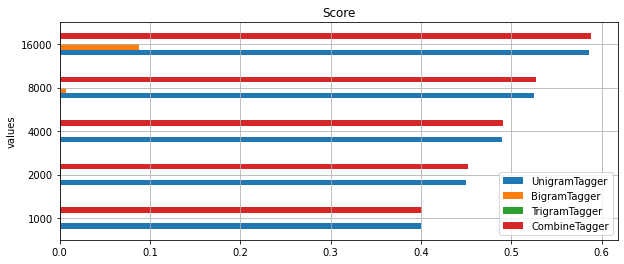

In [8]:
df_score = pd.DataFrame(columns=['values', 'UnigramTagger', 'BigramTagger', 'TrigramTagger']).set_index('values')
COUNT = (1000, 2000, 4000, 8000, 16000)

for C in COUNT:
    
    unigram_tagger = UnigramTagger([train_data[:C]])
    bigram_tagger = BigramTagger([train_data[:C]])
    trigram_tagger = TrigramTagger([train_data[:C]])
    combine_tagger = backoff_tagger([train_data[:C]], [UnigramTagger, BigramTagger, TrigramTagger])

    df_score.loc[C, 'UnigramTagger'] = unigram_tagger.evaluate([test_data])
    df_score.loc[C, 'BigramTagger'] = bigram_tagger.evaluate([test_data])
    df_score.loc[C, 'TrigramTagger'] = trigram_tagger.evaluate([test_data])
    df_score.loc[C, 'CombineTagger'] = combine_tagger.evaluate([test_data])
    
df_score.plot(kind='barh', grid=True, title='Score', figsize=(10,4))
df_score

Вввод:  
- Скорость сильно падает при увеличении количества объектов для обучения  
- Для хорошей точности необходимо большое число объектов > 80000  
- В соло триграмм и биграмм теггеры сильно проигрывают в точности униграмму  
- Комбинация не всегда показывает лучший результат  
- До числа объектов < 8000, скор биграмма не растет  
- При приведении к нижнему регистру всех обучающих данных скор немного поднялся  

### 2. написать свой теггер как на занятии, попробовать разные векторайзеры, добавить знание не только букв но и слов

In [9]:
def split_tok_lbl(data):
  toks = []
  lbls = []

  for tok, lbl in data:
    toks.append(tok)
    lbls.append('NO_TAG' if lbl is None else lbl)

  return toks, lbls

In [10]:
train_tok, train_lbls = split_tok_lbl(train_data)
train_tok[:5], train_lbls[:10]

(['анкета', '.', 'начальник', 'областного', 'управления'],
 ['NOUN',
  'PUNCT',
  'NOUN',
  'ADJ',
  'NOUN',
  'NOUN',
  'PROPN',
  'PROPN',
  'AUX',
  'NOUN'])

In [11]:
test_tok, test_lbls = split_tok_lbl(test_data)
test_tok[:5], test_lbls[:10]

(['алгоритм', ',', 'от', 'имени', 'учёного'],
 ['NOUN',
  'PUNCT',
  'ADP',
  'NOUN',
  'NOUN',
  'PART',
  'PUNCT',
  'PROPN',
  'PUNCT',
  'PUNCT'])

['ADJ' 'ADP' 'ADV' 'AUX' 'CCONJ' 'DET' 'INTJ' 'NOUN' 'NO_TAG' 'NUM' 'PART'
 'PRON' 'PROPN' 'PUNCT' 'SCONJ' 'SYM' 'VERB' 'X']


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


,CastomTagger
vectorizer,
hv_char,0.64407
cv_char,0.757642
hv_word,0.231187
cv_word,0.36021
hv_ch_w,0.703443
cv_ch_w,0.760658


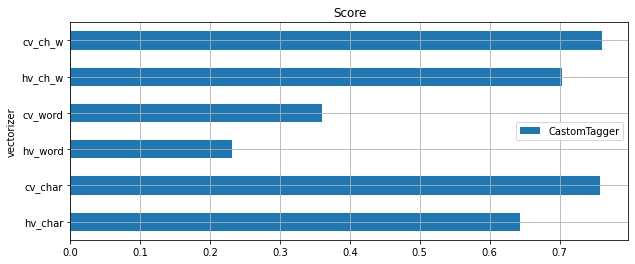

In [12]:
COUNT = 16000

df_score_vec = pd.DataFrame(columns=['vectorizer', 'CastomTagger']).set_index('vectorizer')

le = LabelEncoder()
y_train = le.fit_transform(train_lbls)
y_test = le.transform(test_lbls)
print(le.classes_)

for key_vec, val_vec in {'hv_char': HashingVectorizer(ngram_range=(1,5), analyzer='char', n_features=100),
                         'cv_char': CountVectorizer(ngram_range=(1,5), analyzer='char', max_features=100),
                         'hv_word': HashingVectorizer(ngram_range=(1,5), analyzer='word', n_features=100),
                         'cv_word': CountVectorizer(ngram_range=(1,5), analyzer='word', max_features=100),
                         'hv_ch_w': HashingVectorizer(ngram_range=(1,5), analyzer='char_wb', n_features=100),
                         'cv_ch_w': CountVectorizer(ngram_range=(1,5), analyzer='char_wb', max_features=100)}.items():

    X_train = val_vec.fit_transform(train_tok[:COUNT])
    X_test = val_vec.transform(test_tok)

    lr = LogisticRegression()
    lr.fit(X_train, y_train[:COUNT])
    y_pred = lr.predict(X_test)

    df_score_vec.loc[key_vec, 'CastomTagger'] = accuracy_score(y_test, y_pred)

df_score_vec.plot(kind='barh', grid=True, title='Score', figsize=(10,4))
df_score_vec

Вывод:  
- Лучше всего себя показали комбинации букв и слов  
- Чисто на словах скор сильно упал  

## Задание 2. Проверить насколько хорошо работает NER данные брать из http://www.labinform.ru/pub/named_entities/

In [13]:
!pip install corus
!pip install razdel
!wget http://ai-center.botik.ru/Airec/ai-resources/Persons-1000.zip # ссылка для скачивани на http://www.labinform.ru/pub/named_entities/

     |████████████████████████████████| 83 kB 1.8 MB/s 
--2021-07-23 05:42:50--  http://ai-center.botik.ru/Airec/ai-resources/Persons-1000.zip
Resolving ai-center.botik.ru (ai-center.botik.ru)... 95.129.138.2
Connecting to ai-center.botik.ru (ai-center.botik.ru)|95.129.138.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3363777 (3.2M) [application/zip]
Saving to: ‘Persons-1000.zip’

Persons-1000.zip    100%[===================>]   3.21M  3.12MB/s    in 1.0s    

2021-07-23 05:42:51 (3.12 MB/s) - ‘Persons-1000.zip’ saved [3363777/3363777]



In [14]:
import corus
from razdel import tokenize

In [15]:
path = 'Persons-1000.zip'
records = corus.persons.load_persons(path)
rec = next(records)
rec

PersonsMarkup(
    text='Россия рассчитывает на конструктивное воздействие США на Грузию\r\n\r\n04/08/2008 12:08\r\n\r\nМОСКВА, 4 авг - РИА Новости. Россия рассчитывает, что США воздействуют на Тбилиси в связи с обострением ситуации в зоне грузино-осетинского конфликта. Об этом статс-секретарь - заместитель министра иностранных дел России Григорий Карасин заявил в телефонном разговоре с заместителем госсекретаря США Дэниэлом Фридом.\r\n\r\n"С российской стороны выражена глубокая озабоченность в связи с новым витком напряженности вокруг Южной Осетии, противозаконными действиями грузинской стороны по наращиванию своих вооруженных сил в регионе, бесконтрольным строительством фортификационных сооружений", - говорится в сообщении.\r\n\r\n"Россия уже призвала Тбилиси к ответственной линии и рассчитывает также на конструктивное воздействие со стороны Вашингтона", - сообщил МИД России. ',
    spans=[PersonsSpan(
         id=1,
         start=308,
         stop=324,
         value='ГРИГОРИЙ КАР

In [16]:
word_tag = []

for rec in records:
  for r in rec.spans:
    for t in tokenize(rec.text):
      if (t.start >= r.start) and (t.stop <= r.stop):
        word_tag.append((rec.text[t.start:t.stop], 'PERSON'))
      else:
        word_tag.append((rec.text[t.start:t.stop], 'NO_PERSON'))

print(len(word_tag)) 
print(word_tag[:10])

3715842
[('Комиссар', 'NO_PERSON'), ('СЕ', 'NO_PERSON'), ('критикует', 'NO_PERSON'), ('ограничительную', 'NO_PERSON'), ('политику', 'NO_PERSON'), ('в', 'NO_PERSON'), ('отношении', 'NO_PERSON'), ('беженцев', 'NO_PERSON'), ('в', 'NO_PERSON'), ('европейских', 'NO_PERSON')]


In [17]:
for i in word_tag[:1000]:
  if i[1] == 'PERSON':
    print(i)

('Томас', 'PERSON')
('Хаммарберг', 'PERSON')
('(', 'PERSON')
('Thomas', 'PERSON')
('Hammarberg', 'PERSON')
(')', 'PERSON')
('Хаммарберг', 'PERSON')
('Михаила', 'PERSON')
('Саакашвили', 'PERSON')
('Егора', 'PERSON')
('Борисова', 'PERSON')
('Егора', 'PERSON')
('Борисова', 'PERSON')


### 1. взять нер из nltk

In [18]:
import nltk
nltk.download('words')
nltk.download('maxent_ne_chunker')
nltk.download('names')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Package names is already up-to-date!


True

In [19]:
{(' '.join(c[0] for c in chunk), chunk.label()) for chunk in nltk.ne_chunk(word_tag[:200_000]) if hasattr(chunk, 'label')}

{('AP', 'ORGANIZATION'),
 ('Clinton', 'PERSON'),
 ('HSBC', 'ORGANIZATION'),
 ('John', 'PERSON'),
 ('John Huntsman Jr', 'PERSON'),
 ('John Roos', 'PERSON'),
 ('New York', 'GPE'),
 ('Washington', 'GPE'),
 ('Washington Post', 'ORGANIZATION'),
 ('САО', 'ORGANIZATION')}

Вывод:  
- ne_chunk не распознает имена на кирилице  

## 2. проверить deeppavlov

In [20]:
!python -m venv env
!pip install deeppavlov
!python -m deeppavlov install squad_bert
!python -m deeppavlov install ner_ontonotes

Error: Command '['/content/env/bin/python3', '-Im', 'ensurepip', '--upgrade', '--default-pip']' returned non-zero exit status 1.
     |████████████████████████████████| 907 kB 34.7 MB/s 
     |████████████████████████████████| 65 kB 3.5 MB/s 
     |████████████████████████████████| 10.4 MB 60.5 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
     |████████████████████████████████| 2.1 MB 54.2 MB/s 
     |████████████████████████████████| 510 kB 56.4 MB/s 
     |████████████████████████████████| 1.5 MB 49.2 MB/s 
     |████████████████████████████████| 6.7 MB 45.2 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 57 kB 5.5 MB/s 
     |████████████████████████████████| 654 kB 44.2 MB/s 
     |████████████████████████████████| 8.2 MB 47.9 MB/s 
     |████████████████████████████████| 2.9 MB 48.2 MB/s 
     |████████████████████████████████| 859 kB 38.2 MB/s 
     |████████████████████████████████| 7.3 MB 23.7 MB/s 
     |██

2021-07-23 05:44:55.636 INFO in 'deeppavlov.core.common.file'['file'] at line 32: Interpreting 'squad_bert' as '/usr/local/lib/python3.7/dist-packages/deeppavlov/configs/squad/squad_bert.json'
  Cloning https://github.com/deepmipt/bert.git (to revision feat/multi_gpu) to /tmp/pip-req-build-qcya7cyd
  Running command git clone -q https://github.com/deepmipt/bert.git /tmp/pip-req-build-qcya7cyd
  Created wheel for bert-dp: filename=bert_dp-1.0-py3-none-any.whl size=23591 sha256=d437d6ddd6d7f0d5a9ab3175691806c37de8bc43914bc94ff170af53fa4bed88
  Stored in directory: /tmp/pip-ephem-wheel-cache-amjtgg8e/wheels/44/29/b2/ee614cb7f97ba5c2d220029eaede3af4b74331ad31d6e2f4eb
Successfully built bert-dp
     |████████████████████████████████| 110.5 MB 1.3 MB/s 
     |████████████████████████████████| 503 kB 50.9 MB/s 
     |████████████████████████████████| 3.8 MB 28.7 MB/s 
     |████████████████████████████████| 50 kB 7.2 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=75

In [21]:
import deeppavlov
from deeppavlov import configs, build_model

In [22]:
deeppavlov_ner = build_model(configs.ner.ner_bert_ent_and_type_rus, download=True)

2021-07-23 05:46:08.175 INFO in 'deeppavlov.core.data.utils'['utils'] at line 95: Downloading from http://files.deeppavlov.ai/kbqa/models/ner_cq_rus.tar.gz to /root/.deeppavlov/models/ner_cq_rus.tar.gz
100%|██████████| 1.32G/1.32G [02:18<00:00, 9.54MB/s]
2021-07-23 05:48:27.348 INFO in 'deeppavlov.core.data.utils'['utils'] at line 272: Extracting /root/.deeppavlov/models/ner_cq_rus.tar.gz archive into /root/.deeppavlov/models/ner_ent_and_type_rus
2021-07-23 05:48:42.830 INFO in 'deeppavlov.core.data.utils'['utils'] at line 95: Downloading from http://files.deeppavlov.ai/kbqa/datasets/entity_and_type_detection_rus.pickle to /root/.deeppavlov/models/entity_and_type_detection_rus.pickle
100%|██████████| 2.07M/2.07M [00:00<00:00, 3.02MB/s]
2021-07-23 05:48:45.26 INFO in 'deeppavlov.core.data.utils'['utils'] at line 95: Downloading from http://files.deeppavlov.ai/deeppavlov_data/bert/multi_cased_L-12_H-768_A-12.zip to /root/.deeppavlov/downloads/multi_cased_L-12_H-768_A-12.zip
100%|████████

2021-07-23 05:50:23.519 INFO in 'deeppavlov.core.data.simple_vocab'['simple_vocab'] at line 115: [loading vocabulary from /root/.deeppavlov/models/ner_ent_and_type_rus/tag.dict]











The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


2021-07-23 05:50:52.362 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 51: [loading model from /root/.deeppavlov/models/ner_ent_and_type_rus/model]



INFO:tensorflow:Restoring parameters from /root/.deeppavlov/models/ner_ent_and_type_rus/model


In [23]:
deeppavlov_ner(word_tag[:1000])

[[('Комиссар', 'NO_PERSON'),
  ('СЕ', 'NO_PERSON'),
  ('критикует', 'NO_PERSON'),
  ('ограничительную', 'NO_PERSON'),
  ('политику', 'NO_PERSON'),
  ('в', 'NO_PERSON'),
  ('отношении', 'NO_PERSON'),
  ('беженцев', 'NO_PERSON'),
  ('в', 'NO_PERSON'),
  ('европейских', 'NO_PERSON'),
  ('странах', 'NO_PERSON'),
  ('05/08/2008', 'NO_PERSON'),
  ('10', 'NO_PERSON'),
  (':', 'NO_PERSON'),
  ('32', 'NO_PERSON'),
  ('МОСКВА', 'NO_PERSON'),
  (',', 'NO_PERSON'),
  ('5', 'NO_PERSON'),
  ('августа', 'NO_PERSON'),
  ('/', 'NO_PERSON'),
  ('Новости-Грузия', 'NO_PERSON'),
  ('/', 'NO_PERSON'),
  ('.', 'NO_PERSON'),
  ('Проводимая', 'NO_PERSON'),
  ('в', 'NO_PERSON'),
  ('европейских', 'NO_PERSON'),
  ('странах', 'NO_PERSON'),
  ('ограничительная', 'NO_PERSON'),
  ('политика', 'NO_PERSON'),
  ('в', 'NO_PERSON'),
  ('отношении', 'NO_PERSON'),
  ('беженцев', 'NO_PERSON'),
  ('нарушает', 'NO_PERSON'),
  ('ряд', 'NO_PERSON'),
  ('международных', 'NO_PERSON'),
  ('стандартов', 'NO_PERSON'),
  (',', 'NO_PE

 3. написать свой нер попробовать разные подходы  
 - передаём в сетку токен и его соседей    
 - передаём в сетку только токен


In [24]:
from nltk.tag import SequentialBackoffTagger
from nltk.corpus import names

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

In [25]:
X = []
y = []

for tok, lbl in word_tag:
  X.append(tok)
  y.append(lbl)

X[:5], y[:5]

(['Комиссар', 'СЕ', 'критикует', 'ограничительную', 'политику'],
 ['NO_PERSON', 'NO_PERSON', 'NO_PERSON', 'NO_PERSON', 'NO_PERSON'])

In [26]:
le = LabelEncoder()
y_train_test = le.fit_transform(y)
print(le.classes_)

['NO_PERSON' 'PERSON']


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y_train_test, test_size=0.3)

In [28]:
hvec_ch = HashingVectorizer(ngram_range=(1,5), analyzer='char_wb', n_features=100)

In [29]:
X_train_vec = hvec_ch.fit_transform(X_train)
X_test_vec = hvec_ch.transform(X_test)

In [30]:
lr = LogisticRegression()
lr.fit(X_train_vec, y_train)
y_pred = lr.predict(X_test_vec)

In [31]:
roc_auc_score(y_test, y_pred)

0.5

Вывод:  
roc_auc_score показал, что шанс верного угадывания персоны случаен  
NER из nltk хорошо угадывает персон, чьи имена написаны латиницей